# DIGI405 - Week 6 Lab Notebook - Information Extraction
# Structuring our data in pandas dataframes

<div> 
    <a href="https://pandas.pydata.org/docs/user_guide/index.html">
        <img src='https://pandas.pydata.org/docs/_static/pandas.svg' width="250" align="left"/>
    </a>
</div>
<br>
<br>
<br>
<br>
<br>
<br>
This notebook shows how you can load a corpus of text files into a pandas dataframe and extract various useful pieces of information into separate columns for further analysis.

The notebook uses the qs-v2 dataset that we first explored in Week 1, but the code can be easily adapted to suit other corpora. 

In [17]:
# You only need to run this once (if you don't already have the seaborn package installed)
!pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [18]:
# Import required libraries
import re
import os
import sys
import io
import pickle
import time
import zipfile

import numpy as np
import pandas as pd

import spacy
from spacy.tokens import Doc
from collections import Counter
import math

import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# We are using the smallest spaCy model (size 12MB)
# There are other versions that are more accurate, but also more computationally expensive
# Read more about the available models here: https://spacy.io/models/en

nlp = spacy.load('en_core_web_sm')

---

<span style="color:darkorange">
    Only run the cell below <b> if you get an error</b> loading the spaCy model in the cell above
</span>

---

In [20]:
spacy.cli.download('en_core_web_sm')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


If the model cannot be located, try going to the Kernel menu and selecting 'Restart & Clear Output', then try loading the model again.

An alternate path that may be useful if this is not working is:
```
nlp = spacy.load('/home/#####/.local/lib/python3.8/site-packages/en_core_web_sm/en_core_web_sm-3.0.0')
```
Where ##### is your student userid (e.g. abc123).

---

## Read the text files into a dataframe

The cell below is the function to read the text files in a zip file into a dataframe.

Upload the **zip file** of the qs-v2 corpus to the DIGI405 Jupyter Hub (in the same location as this notebook).

Run this cell:

In [21]:
# Set the name of the zip file, and the folder within the zip file that contains our corpus of text files
my_zip_file = 'nzheraldnew.zip'
my_folder = 'nzheraldnew'


In [93]:
def read_files(my_zip_file, my_folder):
    """
    Given a zip file of Quake Stories text files, read the 
    text files in the given sub-folder into a pandas 
    dataframe with columns for source folder name, text, 
    date, location, and author.
    
    This example assumes filenames are formatted as per the example below: 
    '[2011-07-29] 3 [388 Montreal Street Sydenham Canterbury New Zealand] Anonymous.txt'
    
    Return the dataframe
    """
    
    # Open the zip file in read mode
    with zipfile.ZipFile(my_zip_file, 'r') as my_zip_file:

        # Create a list of tuples, where each tuple contains the folder name, filename, and file object
        folder_name = my_folder
        file_tuples = [(zip_info.filename.split('/')[-2], 
                        zip_info.filename.split('/')[-1], 
                        io.TextIOWrapper(my_zip_file.open(zip_info), encoding='utf-8'))
                       for zip_info in my_zip_file.infolist()
                       if not zip_info.is_dir() and 
                       zip_info.filename.endswith('.txt') and 
                       zip_info.filename.startswith(folder_name + '/')]
        
        # Define a regular expression pattern to extract the date
        date_pattern = r'\d{1,2} [A-Za-z]+, \d{4}'  # Matches "2 Sep, 2022" format
        # Create a list of dictionaries, where each dictionary contains the necessary information extracted from the filename
        data_dicts = []
        for folder_name, filename, file_obj in file_tuples:
            date_match = re.search(date_pattern, filename)
            if date_match:
                date = date_match.group()
            else:
                date = None

            data_dicts.append({
                'filename': filename,
                'folder_name': folder_name,
                'text': file_obj.read(),
                'date': date
            })
    df = pd.DataFrame(data_dicts)
    
    return df

In [94]:
# Let's take a look at our dataframe
# Pass these variables to the read_files() function
df = read_files(my_zip_file,my_folder)
df

,filename,folder_name,text,date
0,"Act Party candidate Elaine Naidu Fr-23 Aug, 20...",nzheraldnew,An Act candidate has resigned after her histor...,"23 Aug, 2023"
1,"Afraid of needles_ China using inha-27 Oct, 20...",nzheraldnew,Authorities in Shanghai have begun administeri...,"27 Oct, 2022"
2,"Appeal planned_ Science teacher dis-21 Dec, 20...",nzheraldnew,A science teacher who was among hundreds of te...,"21 Dec, 2022"
3,"Australia ends Covid travel declara-4 Jul, 202...",nzheraldnew,Australia has said it will open borders to all...,"4 Jul, 2022"
4,"Canterbury businessman admits makin-2 Sep, 202...",nzheraldnew,A Canterbury businessman has today admitted ma...,"2 Sep, 2022"
...,...,...,...,...
94,"Tuberculosis surge_ Killing more pe-9 May, 202...",nzheraldnew,Top UN officials and health industry leaders a...,"9 May, 2023"
95,"Vanuatu drops Covid testing, vaccin-9 Sep, 202...",nzheraldnew,The islands of Vanuatu have confirmed that vis...,"9 Sep, 2022"
96,"Wellington Mayor Andy Foster distan-1 Sep, 202...",nzheraldnew,Wellington Mayor Andy Foster has distanced him...,"1 Sep, 2022"
97,"What to know about the new dominant-23 Aug, 20...",nzheraldnew,"EG.5 is spreading quickly, but experts say it’...","23 Aug, 2023"


In [118]:
# You'll notice the new line characters visible in the text column of the stories (\n) 
# The effect of these can be seen when we print the contents of the cell

story_index = 98

print(df.iloc[story_index]['text'])

The BCG tuberculosis vaccine may protect against Covid-19 and other infections by broadly bolstering the immune system.          In the early days of the Covid-19 pandemic, when prevention seemed light years away, several scientists launched trials          to see whether a tuberculosis vaccine developed in the early 1900s might protect people by bolstering the immune system.         The Bacillus-Calmette-Guerin vaccine has long been known to have broad effects on the immune system, and is still given to infants in the developing world and in countries where TB is prevalent.Scientists observed many years ago that the vaccine seems to train the immune system to respond to a variety of infectious diseases, including viruses, bacteria and parasites, and reduces infant mortality.As new threats like monkeypox and polio re emerge and the coronavirus continues to evolve, the potential of the old vaccine to provide a measure of universal protection against infectious diseases has gained renewe

In [119]:
# The new line characters will cause errors when we try to run our spaCy pipeline
# They are quite simple to remove with a regular expression, and we replace them with a white space

df['text'] = df['text'].str.replace(r'\n+', ' ', regex = True)

In [120]:
# That looks better...
df

,filename,folder_name,text,date,tokens,word_count,DET_freq_per_100k,PROPN_freq_per_100k,NOUN_freq_per_100k,AUX_freq_per_100k,...,ADP_freq_per_100k,PUNCT_freq_per_100k,CCONJ_freq_per_100k,PART_freq_per_100k,NUM_freq_per_100k,ADV_freq_per_100k,SYM_freq_per_100k,SPACE_freq_per_100k,X_freq_per_100k,INTJ_freq_per_100k
0,"Act Party candidate Elaine Naidu Fr-23 Aug, 20...",nzheraldnew,An Act candidate has resigned after her histor...,2023-08-23,"[An, Act, candidate, has, resigned, after, her...",393,8396.946565,13740.458015,18829.516539,8142.493639,...,12213.740458,8905.852417,2035.623410,4071.246819,508.905852,1017.811705,254.452926,254.452926,NaN,NaN
1,"Afraid of needles_ China using inha-27 Oct, 20...",nzheraldnew,Authorities in Shanghai have begun administeri...,2022-10-27,"[Authorities, in, Shanghai, have, begun, admin...",742,9973.045822,8625.336927,23989.218329,5929.919137,...,12398.921833,12803.234501,2291.105121,2021.563342,3638.814016,4312.668464,134.770889,NaN,NaN,NaN
2,"Appeal planned_ Science teacher dis-21 Dec, 20...",nzheraldnew,A science teacher who was among hundreds of te...,2022-12-21,"[A, science, teacher, who, was, among, hundred...",715,11748.251748,14265.734266,19580.419580,5874.125874,...,13566.433566,7692.307692,3356.643357,2377.622378,2237.762238,2517.482517,279.720280,NaN,NaN,NaN
3,"Australia ends Covid travel declara-4 Jul, 202...",nzheraldnew,Australia has said it will open borders to all...,2022-07-04,"[Australia, has, said, it, will, open, borders...",391,5882.352941,13299.232737,21227.621483,5626.598465,...,12276.214834,8951.406650,2301.790281,4092.071611,1278.772379,7161.125320,511.508951,255.754476,255.754476,NaN
4,"Canterbury businessman admits makin-2 Sep, 202...",nzheraldnew,A Canterbury businessman has today admitted ma...,2022-09-02,"[A, Canterbury, businessman, has, today, admit...",470,9361.702128,11063.829787,22765.957447,4893.617021,...,12127.659574,10638.297872,2340.425532,2127.659574,1489.361702,1914.893617,425.531915,212.765957,NaN,212.765957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Tuberculosis surge_ Killing more pe-9 May, 202...",nzheraldnew,Top UN officials and health industry leaders a...,2023-05-09,"[Top, UN, officials, and, health, industry, le...",700,8142.857143,14142.857143,22428.571429,3714.285714,...,13142.857143,14857.142857,4000.000000,2571.428571,2428.571429,3857.142857,285.714286,2000.000000,142.857143,NaN
95,"Vanuatu drops Covid testing, vaccin-9 Sep, 202...",nzheraldnew,The islands of Vanuatu have confirmed that vis...,2022-09-09,"[The, islands, of, Vanuatu, have, confirmed, t...",341,7331.378299,15542.521994,21407.624633,5865.102639,...,12903.225806,10557.184751,2346.041056,3519.061584,293.255132,4985.337243,NaN,NaN,NaN,NaN
96,"Wellington Mayor Andy Foster distan-1 Sep, 202...",nzheraldnew,Wellington Mayor Andy Foster has distanced him...,2022-09-01,"[Wellington, Mayor, Andy, Foster, has, distanc...",573,8726.003490,10122.164049,16055.846422,8726.003490,...,9773.123909,12216.404887,2443.280977,5235.602094,698.080279,5933.682373,NaN,NaN,NaN,174.520070
97,"What to know about the new dominant-23 Aug, 20...",nzheraldnew,"EG.5 is spreading quickly, but experts say it’...",2023-08-23,"[EG.5, is, spreading, quickly, but, experts, s...",867,8996.539792,11534.025375,18454.440600,7035.755479,...,11649.365629,11880.046136,2883.506344,2191.464821,1499.423299,4267.589389,NaN,576.701269,NaN,230.680507


## Extract features ...

In [121]:
# Let's convert our date column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [122]:
# Check the datatype of the 'date' column
print(df['date'].dtype) 

datetime64[ns]


### Tokenization and word count

We can complete simple tokenization of the text by using the first step in the **Spacy** nlp language processing pipeline.
Learn more about the pipeline here: https://spacy.io/usage/processing-pipelines

In [123]:
def spacy_tokenize(text):
    """
    This simple function uses spaCy to 
    tokenize our text.
    
    We will only return the tokens that 
    are not punctuation or whitepace 
    (because we want to count the words)
    """
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space] 
    return tokens

In [125]:
# Apply the function to the 'text' column to create a new 'tokens' column
# This might take a little while to run!
df['tokens'] = df['text'].apply(spacy_tokenize)

In [126]:
# We can use the tokenized text to create a word count column
df["word_count"] = df["tokens"].apply(lambda x: len(x))

In [127]:
df

,filename,folder_name,text,date,tokens,word_count,DET_freq_per_100k,PROPN_freq_per_100k,NOUN_freq_per_100k,AUX_freq_per_100k,...,ADP_freq_per_100k,PUNCT_freq_per_100k,CCONJ_freq_per_100k,PART_freq_per_100k,NUM_freq_per_100k,ADV_freq_per_100k,SYM_freq_per_100k,SPACE_freq_per_100k,X_freq_per_100k,INTJ_freq_per_100k
0,"Act Party candidate Elaine Naidu Fr-23 Aug, 20...",nzheraldnew,An Act candidate has resigned after her histor...,2023-08-23,"[An, Act, candidate, has, resigned, after, her...",393,8396.946565,13740.458015,18829.516539,8142.493639,...,12213.740458,8905.852417,2035.623410,4071.246819,508.905852,1017.811705,254.452926,254.452926,NaN,NaN
1,"Afraid of needles_ China using inha-27 Oct, 20...",nzheraldnew,Authorities in Shanghai have begun administeri...,2022-10-27,"[Authorities, in, Shanghai, have, begun, admin...",742,9973.045822,8625.336927,23989.218329,5929.919137,...,12398.921833,12803.234501,2291.105121,2021.563342,3638.814016,4312.668464,134.770889,NaN,NaN,NaN
2,"Appeal planned_ Science teacher dis-21 Dec, 20...",nzheraldnew,A science teacher who was among hundreds of te...,2022-12-21,"[A, science, teacher, who, was, among, hundred...",715,11748.251748,14265.734266,19580.419580,5874.125874,...,13566.433566,7692.307692,3356.643357,2377.622378,2237.762238,2517.482517,279.720280,NaN,NaN,NaN
3,"Australia ends Covid travel declara-4 Jul, 202...",nzheraldnew,Australia has said it will open borders to all...,2022-07-04,"[Australia, has, said, it, will, open, borders...",391,5882.352941,13299.232737,21227.621483,5626.598465,...,12276.214834,8951.406650,2301.790281,4092.071611,1278.772379,7161.125320,511.508951,255.754476,255.754476,NaN
4,"Canterbury businessman admits makin-2 Sep, 202...",nzheraldnew,A Canterbury businessman has today admitted ma...,2022-09-02,"[A, Canterbury, businessman, has, today, admit...",470,9361.702128,11063.829787,22765.957447,4893.617021,...,12127.659574,10638.297872,2340.425532,2127.659574,1489.361702,1914.893617,425.531915,212.765957,NaN,212.765957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Tuberculosis surge_ Killing more pe-9 May, 202...",nzheraldnew,Top UN officials and health industry leaders a...,2023-05-09,"[Top, UN, officials, and, health, industry, le...",700,8142.857143,14142.857143,22428.571429,3714.285714,...,13142.857143,14857.142857,4000.000000,2571.428571,2428.571429,3857.142857,285.714286,2000.000000,142.857143,NaN
95,"Vanuatu drops Covid testing, vaccin-9 Sep, 202...",nzheraldnew,The islands of Vanuatu have confirmed that vis...,2022-09-09,"[The, islands, of, Vanuatu, have, confirmed, t...",341,7331.378299,15542.521994,21407.624633,5865.102639,...,12903.225806,10557.184751,2346.041056,3519.061584,293.255132,4985.337243,NaN,NaN,NaN,NaN
96,"Wellington Mayor Andy Foster distan-1 Sep, 202...",nzheraldnew,Wellington Mayor Andy Foster has distanced him...,2022-09-01,"[Wellington, Mayor, Andy, Foster, has, distanc...",573,8726.003490,10122.164049,16055.846422,8726.003490,...,9773.123909,12216.404887,2443.280977,5235.602094,698.080279,5933.682373,NaN,NaN,NaN,174.520070
97,"What to know about the new dominant-23 Aug, 20...",nzheraldnew,"EG.5 is spreading quickly, but experts say it’...",2023-08-23,"[EG.5, is, spreading, quickly, but, experts, s...",867,8996.539792,11534.025375,18454.440600,7035.755479,...,11649.365629,11880.046136,2883.506344,2191.464821,1499.423299,4267.589389,NaN,576.701269,NaN,230.680507


### Parts of Speech tagging with Spacy

Here we will count each part-of-speech in each text using the **Universal pos_ tags** in Spacy (see https://universaldependencies.org/u/pos/ for more information about the tags). 


We will divide by our word count and multiply by 100,000 to get the frequency of each part of speech per hundred thousand words.

In [128]:
def univ_pos(df):
    """
    Count the parts of speech 
    """    
    for index, row in df.iterrows():
        len_x = row['word_count']
        doc = row['text']
        pos = [token.pos_ for token in nlp(doc)]
        pos_freq = Counter(pos)
        for pos in pos_freq:
            freq_pos_per_100k = (pos_freq[pos]/len_x) * 100000
            df.loc[index, f'{pos}_freq_per_100k'] = freq_pos_per_100k
    return df 

In [129]:
# Again, this might take a little while to run!
df = univ_pos(df)

In [130]:
df

,filename,folder_name,text,date,tokens,word_count,DET_freq_per_100k,PROPN_freq_per_100k,NOUN_freq_per_100k,AUX_freq_per_100k,...,ADP_freq_per_100k,PUNCT_freq_per_100k,CCONJ_freq_per_100k,PART_freq_per_100k,NUM_freq_per_100k,ADV_freq_per_100k,SYM_freq_per_100k,SPACE_freq_per_100k,X_freq_per_100k,INTJ_freq_per_100k
0,"Act Party candidate Elaine Naidu Fr-23 Aug, 20...",nzheraldnew,An Act candidate has resigned after her histor...,2023-08-23,"[An, Act, candidate, has, resigned, after, her...",393,8396.946565,13740.458015,18829.516539,8142.493639,...,12213.740458,8905.852417,2035.623410,4071.246819,508.905852,1017.811705,254.452926,254.452926,NaN,NaN
1,"Afraid of needles_ China using inha-27 Oct, 20...",nzheraldnew,Authorities in Shanghai have begun administeri...,2022-10-27,"[Authorities, in, Shanghai, have, begun, admin...",742,9973.045822,8625.336927,23989.218329,5929.919137,...,12398.921833,12803.234501,2291.105121,2021.563342,3638.814016,4312.668464,134.770889,NaN,NaN,NaN
2,"Appeal planned_ Science teacher dis-21 Dec, 20...",nzheraldnew,A science teacher who was among hundreds of te...,2022-12-21,"[A, science, teacher, who, was, among, hundred...",715,11748.251748,14265.734266,19580.419580,5874.125874,...,13566.433566,7692.307692,3356.643357,2377.622378,2237.762238,2517.482517,279.720280,NaN,NaN,NaN
3,"Australia ends Covid travel declara-4 Jul, 202...",nzheraldnew,Australia has said it will open borders to all...,2022-07-04,"[Australia, has, said, it, will, open, borders...",391,5882.352941,13299.232737,21227.621483,5626.598465,...,12276.214834,8951.406650,2301.790281,4092.071611,1278.772379,7161.125320,511.508951,255.754476,255.754476,NaN
4,"Canterbury businessman admits makin-2 Sep, 202...",nzheraldnew,A Canterbury businessman has today admitted ma...,2022-09-02,"[A, Canterbury, businessman, has, today, admit...",470,9361.702128,11063.829787,22765.957447,4893.617021,...,12127.659574,10638.297872,2340.425532,2127.659574,1489.361702,1914.893617,425.531915,212.765957,NaN,212.765957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Tuberculosis surge_ Killing more pe-9 May, 202...",nzheraldnew,Top UN officials and health industry leaders a...,2023-05-09,"[Top, UN, officials, and, health, industry, le...",700,8142.857143,14142.857143,22428.571429,3714.285714,...,13142.857143,14857.142857,4000.000000,2571.428571,2428.571429,3857.142857,285.714286,2000.000000,142.857143,NaN
95,"Vanuatu drops Covid testing, vaccin-9 Sep, 202...",nzheraldnew,The islands of Vanuatu have confirmed that vis...,2022-09-09,"[The, islands, of, Vanuatu, have, confirmed, t...",341,7331.378299,15542.521994,21407.624633,5865.102639,...,12903.225806,10557.184751,2346.041056,3519.061584,293.255132,4985.337243,NaN,NaN,NaN,NaN
96,"Wellington Mayor Andy Foster distan-1 Sep, 202...",nzheraldnew,Wellington Mayor Andy Foster has distanced him...,2022-09-01,"[Wellington, Mayor, Andy, Foster, has, distanc...",573,8726.003490,10122.164049,16055.846422,8726.003490,...,9773.123909,12216.404887,2443.280977,5235.602094,698.080279,5933.682373,NaN,NaN,NaN,174.520070
97,"What to know about the new dominant-23 Aug, 20...",nzheraldnew,"EG.5 is spreading quickly, but experts say it’...",2023-08-23,"[EG.5, is, spreading, quickly, but, experts, s...",867,8996.539792,11534.025375,18454.440600,7035.755479,...,11649.365629,11880.046136,2883.506344,2191.464821,1499.423299,4267.589389,NaN,576.701269,NaN,230.680507


In [131]:
# View the dataframe column names
for column in df.columns:
    print(column)

filename
folder_name
text
date
tokens
word_count
DET_freq_per_100k
PROPN_freq_per_100k
NOUN_freq_per_100k
AUX_freq_per_100k
VERB_freq_per_100k
SCONJ_freq_per_100k
PRON_freq_per_100k
ADJ_freq_per_100k
ADP_freq_per_100k
PUNCT_freq_per_100k
CCONJ_freq_per_100k
PART_freq_per_100k
NUM_freq_per_100k
ADV_freq_per_100k
SYM_freq_per_100k
SPACE_freq_per_100k
X_freq_per_100k
INTJ_freq_per_100k


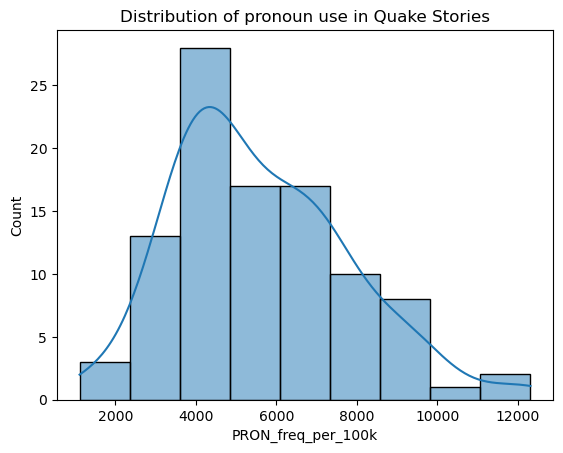

In [132]:
# Let's make a histogram to see the distribution of pronoun use in the stories
sns.histplot(data = df, x = 'PRON_freq_per_100k', kde=True).set(title='Distribution of pronoun use in Quake Stories')
plt.savefig("histplot.png") # This saves the plot as an image that we can insert into a document (you'll see it appear in the files in your directory)
plt.show()

In [133]:
# We can inspect the highest outlier by looking for the index of the highest pronoun frequency value

max_pronouns = df['PRON_freq_per_100k'].idxmax()
doc = nlp(df.iloc[max_pronouns]['text'])
my_pronouns = [token.text for token in doc if token.pos_ == "PRON"]

print(f'\n----------\nIndex: {max_pronouns}\n----------')
display(df.loc[[max_pronouns]])
print(f'\n----------\n')
print(df.iloc[max_pronouns]['text'])
print(f'\n----------\n')
print(f'PRONOUNS (count = {len(my_pronouns)})\n----------------------\n')
print(my_pronouns)


----------
Index: 70
----------


,filename,folder_name,text,date,tokens,word_count,DET_freq_per_100k,PROPN_freq_per_100k,NOUN_freq_per_100k,AUX_freq_per_100k,...,ADP_freq_per_100k,PUNCT_freq_per_100k,CCONJ_freq_per_100k,PART_freq_per_100k,NUM_freq_per_100k,ADV_freq_per_100k,SYM_freq_per_100k,SPACE_freq_per_100k,X_freq_per_100k,INTJ_freq_per_100k
70,"I used to be_ Climate change and Co-6 Nov, 202...",nzheraldnew,"Kids do it on a dime. But for adults, changing...",2022-11-06,"[Kids, do, it, on, a, dime, But, for, adults, ...",4468,6557.743957,7072.515667,19583.706356,7743.957028,...,9467.323187,15174.574754,3312.444047,3939.12265,1924.798568,5461.056401,290.957923,492.390331,290.957923,380.483438



----------

Kids do it on a dime. But for adults, changing our minds on something, or flipping our behaviour, doesn't come so easy. Cherie Howie asks four people how they managed it.          'You start realising there's          a problem': When the odd weather becomes the norm         George Moss used to be sceptical of climate change. Now he's a Dairy NZ climate change ambassador. Photo / Mike ScottIt's so much easier when you decide a problem like climate change isn't real, that today is what matters, not yesterday, and certainly not tomorrow.Although he wouldn't call himself a reformed climate change denier, he's certainly a reformed sceptic, Tokoroa farmer and climate action advocate George Moss says."[Before] I was at the 'don't want to believe it' stage, so you look for those things that justify the status quo."It was a nice place to be, for him, and for those who still believe long-term changes in global temperatures and weather patterns aren't because we're all burning too m

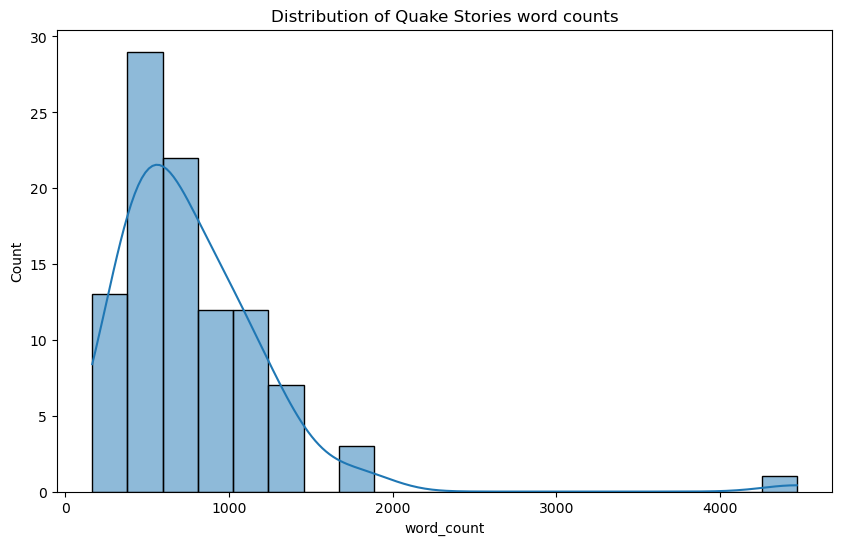

In [134]:
# Interesting! 
# Let's take a look at the distribution of word count

plt.figure(figsize = (10,6))
sns.histplot(data = df, x = 'word_count', bins = 20, kde=True) \
             .set(title = 'Distribution of Quake Stories word counts')
plt.show()

### Named entity tagging with Spacy

We can also extract the named entities in our stories, and add them as a list of tuples in a dataframe column

In [135]:
def get_named_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [136]:
df['named_entities'] = df['text'].apply(get_named_entities)

In [137]:
# Scroll across to see the column of named entities added to the dataframe
df

,filename,folder_name,text,date,tokens,word_count,DET_freq_per_100k,PROPN_freq_per_100k,NOUN_freq_per_100k,AUX_freq_per_100k,...,PUNCT_freq_per_100k,CCONJ_freq_per_100k,PART_freq_per_100k,NUM_freq_per_100k,ADV_freq_per_100k,SYM_freq_per_100k,SPACE_freq_per_100k,X_freq_per_100k,INTJ_freq_per_100k,named_entities
0,"Act Party candidate Elaine Naidu Fr-23 Aug, 20...",nzheraldnew,An Act candidate has resigned after her histor...,2023-08-23,"[An, Act, candidate, has, resigned, after, her...",393,8396.946565,13740.458015,18829.516539,8142.493639,...,8905.852417,2035.623410,4071.246819,508.905852,1017.811705,254.452926,254.452926,NaN,NaN,"[(Nazi, NORP), (David Seymour, PERSON), (Rangi..."
1,"Afraid of needles_ China using inha-27 Oct, 20...",nzheraldnew,Authorities in Shanghai have begun administeri...,2022-10-27,"[Authorities, in, Shanghai, have, begun, admin...",742,9973.045822,8625.336927,23989.218329,5929.919137,...,12803.234501,2291.105121,2021.563342,3638.814016,4312.668464,134.770889,NaN,NaN,NaN,"[(Shanghai, GPE), (Covid, PERSON), (19, CARDIN..."
2,"Appeal planned_ Science teacher dis-21 Dec, 20...",nzheraldnew,A science teacher who was among hundreds of te...,2022-12-21,"[A, science, teacher, who, was, among, hundred...",715,11748.251748,14265.734266,19580.419580,5874.125874,...,7692.307692,3356.643357,2377.622378,2237.762238,2517.482517,279.720280,NaN,NaN,NaN,"[(hundreds, CARDINAL), (Taupo Intermediate Sch..."
3,"Australia ends Covid travel declara-4 Jul, 202...",nzheraldnew,Australia has said it will open borders to all...,2022-07-04,"[Australia, has, said, it, will, open, borders...",391,5882.352941,13299.232737,21227.621483,5626.598465,...,8951.406650,2301.790281,4092.071611,1278.772379,7161.125320,511.508951,255.754476,255.754476,NaN,"[(Australia, GPE), (Wednesday, DATE), (Austral..."
4,"Canterbury businessman admits makin-2 Sep, 202...",nzheraldnew,A Canterbury businessman has today admitted ma...,2022-09-02,"[A, Canterbury, businessman, has, today, admit...",470,9361.702128,11063.829787,22765.957447,4893.617021,...,10638.297872,2340.425532,2127.659574,1489.361702,1914.893617,425.531915,212.765957,NaN,212.765957,"[(Canterbury, GPE), (today, DATE), (60s, DATE)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Tuberculosis surge_ Killing more pe-9 May, 202...",nzheraldnew,Top UN officials and health industry leaders a...,2023-05-09,"[Top, UN, officials, and, health, industry, le...",700,8142.857143,14142.857143,22428.571429,3714.285714,...,14857.142857,4000.000000,2571.428571,2428.571429,3857.142857,285.714286,2000.000000,142.857143,NaN,"[(UN, ORG), (Ukraine, GPE), (Sudan, GPE), (tod..."
95,"Vanuatu drops Covid testing, vaccin-9 Sep, 202...",nzheraldnew,The islands of Vanuatu have confirmed that vis...,2022-09-09,"[The, islands, of, Vanuatu, have, confirmed, t...",341,7331.378299,15542.521994,21407.624633,5865.102639,...,10557.184751,2346.041056,3519.061584,293.255132,4985.337243,NaN,NaN,NaN,NaN,"[(Vanuatu, PERSON), (the Vanuatu Tourism Offic..."
96,"Wellington Mayor Andy Foster distan-1 Sep, 202...",nzheraldnew,Wellington Mayor Andy Foster has distanced him...,2022-09-01,"[Wellington, Mayor, Andy, Foster, has, distanc...",573,8726.003490,10122.164049,16055.846422,8726.003490,...,12216.404887,2443.280977,5235.602094,698.080279,5933.682373,NaN,NaN,NaN,174.520070,"[(Wellington, GPE), (Andy Foster, PERSON), (Fo..."
97,"What to know about the new dominant-23 Aug, 20...",nzheraldnew,"EG.5 is spreading quickly, but experts say it’...",2023-08-23,"[EG.5, is, spreading, quickly, but, experts, s...",867,8996.539792,11534.025375,18454.440600,7035.755479,...,11880.046136,2883.506344,2191.464821,1499.423299,4267.589389,NaN,576.701269,NaN,230.680507,"[(This month, DATE), (the United States, GPE),..."


In [138]:
# Find out the meaning of a specific label
print(spacy.explain('NORP'))

Nationalities or religious or political groups


In [140]:
# Inspect the named entities in a given story
# Story number 107 has a number of correctly tagged dates and times

view_story_index = 98

doc = nlp(df.iloc[view_story_index]['text'])
spacy.displacy.render(doc, style="ent", jupyter=True)

In [142]:
# Inspect the named entities in a given story
# Story number 250 has quite a mixture of tags, many are incorrect!

view_story_index = 98

doc = nlp(df.iloc[view_story_index]['text'])
spacy.displacy.render(doc, style="ent", jupyter=True)

---

## Save the dataframe
Our dataframe can be saved in [pickle](https://docs.python.org/3/library/pickle.html) format so we can access it again later or use it in a different notebook.

We can also save the dataframe as a csv file, which we can open in Excel for additional filtering or sorting.

In [144]:
pkl_filename = 'nzherald' # Change filename here

In [145]:
df.to_pickle(f"{pkl_filename}.pkl")

In [147]:
# To keep our csv file compact in this case, we will drop the 'text' and 'tokens' columns (we have these in the corpus text files)
df_without_text = df.drop(columns=['text', 'tokens'])
df_without_text.to_csv(f"{pkl_filename}_text_dropped.csv")